# Part I

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import two_player_game1 as tpg1
import two_player_game2 as tpg2

In [2]:
high = 0
low = 1
actions = [high, low] #player can choose to invest high effort or low effort each round

ph = 0.55 #Probability of winning if player invests high effort
pl = 0.45 #Probability of winning if player invests low effort
ch = 50 #Cost of investing high effort
cl = 10 #Cost of investing low effort
R = 1000 #Reward for winning (i.e. reaching state d=3)

## 1.)  Iterative Evaluation of all Deterministic Policies

**NOTE: Throughout this analysis, the actions will be encoded as follows: High Effort = 0 and Low Effort = 1**

There are 5 non-terminal states in the environment, corresponding to $d \in [-2,-1,0,1,2]$ and 2 terminal states, where $d = \pm 3$. Considering these 5 non-terminal states, since there are two possible actions (high and low effort) that can be taken in each state, there are $2^5 = 32$ possible deterministic policies. (For example, one such possible is exerting high effort in every state.)

Using iterative policy evaluation, we can see that the optimal policy, which is the one resulting in the highest value for the initial state of $d=0$, is $[low, low, low, high, high]$. Under this deterministic policy, if the player is tied with or has won fewer games than his opponent ($-3<d\le0$), he exerts low effort, and if he has won more games ($0<d<3$), he exerts high effort. Assuming that the reward for winning the game is 1,000 and that the player follows this optimal policy, then the value of the initial state of this game is about 281.65. The bar plot belows shows that the most lucrative policies all involve exerting low effort when tied or losing, at least for the specified parameters above.

Optimal policy is (1, 1, 1, 0, 0)
Initial state's value under this policy is 281.6528902232666



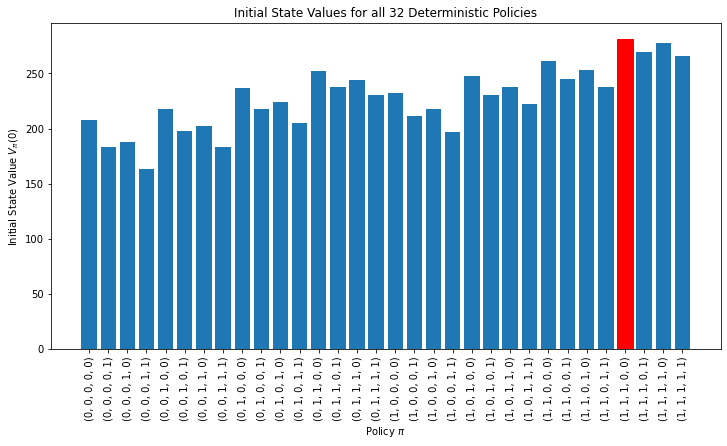

In [3]:
def iter_policy_eval(policy):
    theta = 1e-6
    delta = 0
    gamma = 1
    state_vals = [0,0,0,0,0,0,0] 
    termination = False
    while(not termination):
        delta = 0.0
        #Store copy of current state values
        v_old = np.copy(state_vals) 
        #Iterate through all states to compute state values
        for j in range(1,len(state_vals)-1):
            win_prob = ph if policy[j-1] == 0 else pl
            reward = -ch if policy[j-1] == 0 else -cl
            if j == 5: #Special condition if a win from this state leads to victory
                state_vals[j] = win_prob*(reward + R + gamma * v_old[j+1]) + (1-win_prob)*(reward + gamma * v_old[j-1])
            else:
                state_vals[j] = win_prob*(gamma*v_old[j+1]+reward) + (1-win_prob)*(gamma*v_old[j-1]+reward)
            delta = np.maximum(delta, np.abs(v_old[j] - state_vals[j])) #Update delta
        if delta < theta: #Determine whether termination criteria is met
            termination = True

    return state_vals

import itertools
policies = list(itertools.product(actions, repeat=5)) #generate all possible deterministic policies
state_values = [iter_policy_eval(p) for p in policies] #compute state values for each policy
pol_number = np.argmax([val[3] for val in state_values]) #retrieve policy with highest initial state value 
pol_value_init = np.max([val[3] for val in state_values]) #retrieve the corresponding value from this policy
print('Optimal policy is {}'.format(policies[pol_number]))
print('Initial state\'s value under this policy is {}\n'.format(pol_value_init))
#Plot initial state values for all 32 policies
labels = [str(p) for p in policies]
fig, ax = plt.subplots(figsize=(12,6))
bars = plt.bar(range(32),[val[3] for val in state_values], label=policies)
bars[28].set_color('red')
plt.xlabel('Policy $\pi$')
plt.ylabel('Initial State Value $V_{\pi}(0)$')
# ax.set_xticklabels(labels)
plt.xticks(np.arange(32),rotation=90, labels=labels)
plt.title('Initial State Values for all 32 Deterministic Policies');

## 2.) Monte Carlo Off-Policy Evaluation

Using Monte Carlo methods, we can generate sample "episodes" of the game, where each episode consists of one full play-through of the game. From this sample, we can estimate the action-values on an episode-by-episode basis; however, because we have to wait for the conclusion of each episode to update our estimates, this method can suffer from high variance and thus require a very large number of episodes to converge to accurate action-values.

Implementing Monte Carlo off-policy evaluation, I found that even with 500,000 episodes, my action values fluctuated somewhat significantly each time, as does the optimal policy. This is possibly because 500,000 episodes is not enough to lead to convergence, or it could be because the win probabilities $p_{High}=0.55$ and $p_{Low}=0.45$ are too close together, making it difficult to distinguish between the actions due to random chance. To compensate for this instability, I treated each run of 500,000 episodes as a simulation and ran the simulation 10 times. Averaging these results, I obtain the following action-values, which I found to be more robust to random variation:


| State | Actions | |
| --------- | ----------- | ---------- |
|          | High Effort | Low Effort |
| d = -3 | 0 | 0 |
| d = -2 | 27.52 | **29.81** |
| d = -1 | 68.44|**135.70** |
| d = 0 | **271.22**|223.07 |
| d = 1 |**491.56** | 468.64|
| d = 2 |**751.88**|661.14|
| d = 3 | 0 | 0 |

As we can see from the bolded actions values (which are optimal given each state), the target policy specified below is not the optimal one. The optimal policy according to this MC estimation method is to invest low effort when losing and high effort when tied or winning. Reassuringly, this is very similar to the optimal policy found in part I using the initial state values (the only difference is the suggested action when $d=0$). In fact, the plot in part I shows that this policy of $[low, low, high, high, high]$ ranks in the top 5 in terms of initial state value. This gives us greater confidence that our results here make sense.

In [4]:
#Target policy here is to always choose high effort unless winning by 2 rounds
def target_policy(d):
    return 0 if d <= 1 else 1
#Random behavioral policy
def behavior_policy():
    return np.random.binomial(1, 0.5)

env = tpg1.two_player_game1()

In [5]:
def MC_offpolicy_eval(target_policy, gamma=1, n_episodes=500000):
    Q = np.zeros((7,2))
    C = np.zeros_like(Q)
    for ep in range(n_episodes):    
        done = False
        env.reset()
        history = {'states':[0], 'actions':[], 'rewards':[]}
        #Generate data according to behavior policy
        while not done:
            action = behavior_policy()
            state, reward, done = env.step(action)
            history['states'].append(state)
            history['actions'].append(action)
            history['rewards'].append(reward)
            G=0
            W=1
        #Evaluate target policy
        for i in range(len(history['actions'])-1, -1, -1):
            state, action, reward = history['states'][i], history['actions'][i], history['rewards'][i]
            G = gamma*G + reward 
            C[state+3][action] += W
            #Update action values
            Q[state+3][action] = Q[state+3][action] + (W/C[state+3][action])*(G-Q[state+3][action])
            #Depending on state, target policy always or never takes the given action (deterministic)
            target_prob = 1 if action == target_policy(state) else 0 
            behavior_prob = 0.5 #Always 0.5 prob of choosing either action, regardless of state
            #Update importance weights
            W = W*target_prob/behavior_prob
            #Exit loop if weight = 0
            if W == 0:
                break
    return Q

In [6]:
# Conduct 10 runs of 500,000 episodes each
Q_avg = np.zeros((7,2))
runs = 10

np.random.seed(1)
for _ in range(runs):
    Q_avg += MC_offpolicy_eval(target_policy)
#Average action-values of the 10 runs
Q_avg /= runs
Q_avg

array([[  0.        ,   0.        ],
       [ 27.51706568,  29.80957067],
       [ 68.44108131, 135.69912484],
       [271.22456805, 223.07100736],
       [491.56175508, 468.6396233 ],
       [751.87924601, 661.13557219],
       [  0.        ,   0.        ]])

## 3.) Monte Carlo Off-Policy Control

Monte Carlo control is very similar to evaluation, with an extra step. After generating data according to a random behavior policy, the algorithm updates the action-values, just as done above. But control introduces a policy improvement element, in which the target policy greedily chooses the most valuable action at every step. This policy improvement procedure is guaranteed to yield a policy that is at least as good if not better than the existing target policy, and it allows for iterative improvement of the target policy. 

Again, for the same reasons as above, my results are subject to random variation, but now there is an additional reason: if the action taken by the behavior policy is different than the one the target policy would have taken at that step, then the episode ends. This can lead to some extremely short episodes, which introduces even more variance into the results. I omit the 10-run simulation here because the goal of off-policy control is to return a policy rather than a set of values that can be averaged together, but I want to note that this algorithm likely needs more episodes or more separation between the actions' win probabilities.

We can see that through off-policy control, we obtain an optimal target policy of $[low, high, high, high, low]$. Some of the pairs of action values (e.g. for $d=0$) are extremely similar, demonstrating how different runs of the algorithms can yield different optimal policies. The action values do make sense, gradually increasing as the player gets closer to winning the game:

| State | Actions | |
| --------- | ----------- | ---------- |
|          | High Effort | Low Effort |
| d = -3 | 0 | 0 |
| d = -2 | 47.06 | **53.53** |
| d = -1 | **177.93**|166.00 |
| d = 0 | **347.96**|344.97 |
| d = 1 |**585.16** | 556.86|
| d = 2 |744.83|**797.98**|
| d = 3 | 0 | 0 |


In [7]:
def MC_offpolicy_ctrl(gamma=1, n_episodes=500000):
    Q = np.zeros((7,2))
    C = np.zeros_like(Q)
    target_policy = np.zeros(7) #Arbitrary initialization of target policy
    for ep in range(n_episodes):    
        done = False
        env.reset()
        history = {'states':[0], 'actions':[], 'rewards':[]}
        #Generate data according to behavior policy
        while not done:
            action = behavior_policy()
            state, reward, done = env.step(action)
            history['states'].append(state)
            history['actions'].append(action)
            history['rewards'].append(reward)
            G=0
            W=1
        #Evaluate target policy
        for i in range(len(history['actions'])-1, -1, -1):
            state, action, reward = history['states'][i], history['actions'][i], history['rewards'][i]
            G = gamma*G + reward
            C[state+3][action] += W
            Q[state+3][action] = Q[state+3][action] + (W/C[state+3][action])*(G-Q[state+3][action])
            #Improve target policy greedily
            target_policy[state+3] = np.argmax(Q[state+3])
            behavior_prob = 0.5 #Always 0.5 prob of choosing either action, regardless of state
            W = W*1/behavior_prob
            if target_policy[state+3] != action:
                break
    return target_policy[1:6], Q

In [8]:
np.random.seed(1)
MC_offpolicy_ctrl()

(array([1., 0., 0., 0., 1.]),
 array([[  0.        ,   0.        ],
        [ 47.05698557,  53.52835735],
        [177.92650552, 166.00457419],
        [347.95646706, 344.96646303],
        [585.16292104, 556.86255089],
        [744.82550574, 797.9760042 ],
        [  0.        ,   0.        ]]))

# Part II
## 1.) Q-Learning algorithm
We move now to Temporal Difference (TD) methods. The first is Q-learning, an off-policy TD control method. In this implementation, the behavior policy is $\epsilon$-greedy, while the the target policy used for learning is greedy. Just as with off-policy MC control, the behavior policy determines which states and actions are visited, and so we need it to be exploring the entire state-action space, which is a fair assumption given $\epsilon=0.1$ over 500,000 episodes.

Q-learning yields an optimal policy of $[low, low, low, high, high]$, which is identical to the optimal policy obtained through iterative evaluation in part I above. The results here are also stabler than the Monte Carlo results; if I rerun the simulation I get the same optimal policy. The action values obtained from Q-learning are:


| State | Actions | |
| --------- | ----------- | ---------- |
|          | High Effort | Low Effort |
| d = -3 | 0 | 0 |
| d = -2 | 29.54 | **54.25** |
| d = -1 | 132.02|**148.67** |
| d = 0 | 274.65|**289.74** |
| d = 1 |**469.42** | 461.88|
| d = 2 |**710.84**|691.73|
| d = 3 | 0 | 0 |

In [9]:
def eps_greedy(q_values, eps=0.1):
    if np.random.binomial(1, eps) == 1:
        return np.random.choice(np.arange(len(q_values)))
    else:
        return np.argmax(q_values)
    
env = tpg1.two_player_game1()

In [10]:
def q_learning(n_episodes=500000, eta=0.001, gamma=1):
    Q = np.zeros((7,2))
    rewards = np.zeros(n_episodes)
    for ep in range(n_episodes):
        env.reset()
        state = 0 #Initial state
        done = False
        while not done:
            #Choose action given state
            action = eps_greedy(Q[state+3])
            next_state, reward, done = env.step(action)
            #Updates
            Q[state+3, action] = Q[state+3, action] + \
                                        eta*(reward + gamma * np.max(Q[next_state+3]) - Q[state+3,action])
            state = next_state
    return Q

In [11]:
np.random.seed(1)
q_vals = q_learning()
print(q_vals)
np.argmax(q_vals, axis=1)

[[  0.           0.        ]
 [ 29.5419813   54.25199292]
 [132.02000078 148.66549623]
 [274.6541277  289.74485752]
 [469.41962209 461.87879183]
 [710.83897043 691.73465477]
 [  0.           0.        ]]


array([0, 1, 1, 1, 0, 0, 0])

## 2.) SARSA algorithm

The SARSA algorithm is very similar to Q-learning, utilizing for policy improvement the quintuple of values $(s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1})$ that give it its name. The key difference is that at each step, the $a_t$ and $a_{t+1}$ are chosen according to the same policy (in this case $\epsilon$-greedy), so SARSA is an on-policy learning method. 

SARSA yields the same optimal policy as Q-learning of $[low, low, low, high, high]$, and again this result is robust to random variation if I rerun the algorithm. The action-values are also extremely similar to the ones obtained from Q-learning. Both of these results provide a nice demonstration of the advantages of TD methods, which can update step-by-step within an episode, compared to the episode-by-episode updating structure in MC methods. For a game such as this one with so much variation, TD methods are able to yield estimates that converge much faster and are subject to less variation. Here are the estimated action-values:

| State | Actions | |
| --------- | ----------- | ---------- |
|          | High Effort | Low Effort |
| d = -3 | 0 | 0 |
| d = -2 | 26.04 | **53.82** |
| d = -1 | 119.35|**141.19** |
| d = 0 | 262.63|**271.05** |
| d = 1 |**458.49** | 451.63|
| d = 2 |**700.12**|679.58|
| d = 3 | 0 | 0 |

In [12]:
def sarsa(n_episodes=500000, eta=0.001, gamma=1):
    Q = np.zeros((7,2))
    rewards = np.zeros(n_episodes)
    for ep in range(n_episodes):
        env.reset()
        state = 0 #Initial state
        done = False
        action = eps_greedy(Q[state+3]) #Choose action according to eps greedy

        while not done:
            next_state, reward, done = env.step(action)
            next_action = eps_greedy(Q[next_state+3]) #Next action chosen according to same eps greedy policy 
            #Updates
            Q[state+3, action] = Q[state+3, action] + \
                                        eta*(reward + gamma * Q[next_state+3, next_action] - Q[state+3,action])
            state = next_state
            action = next_action

    return Q

In [13]:
np.random.seed(1)
q_vals = sarsa()
print(q_vals)
np.argmax(q_vals, axis=1)

[[  0.           0.        ]
 [ 26.04403363  53.81995496]
 [119.35399459 141.19028847]
 [262.62822186 271.04579305]
 [458.49044489 451.6345784 ]
 [700.12340078 679.5771637 ]
 [  0.           0.        ]]


array([0, 1, 1, 1, 0, 0, 0])

## 3.) TD($\lambda$) algorithm

Finally, we use TD($\lambda$) to evaluate the performance of an agent that uses a random policy to play the game. Unlike Q-learning and SARSA, TD($\lambda$) incorporates the use of eligibility traces, which is essentially a way to track which states are "eligible" for learning, based on the frequencies of visits to those states. **Note**: The older edition of Barto and Sutton's *Reinforcement Learning: An Introduction* fails to include in the pseudocode for TD($\lambda$) and SARSA($\lambda$) that the eligibility traces should be reset at the start of each episode, but I do so here because this seems to have been a typo (and it doesn't make sense for state visits in episode *t* to be carried over to episode $t+1$). 

In the TD($\lambda$) algorithm, $\lambda \in [0,1] $ is a hyperparameter that allows the algorithm to bridge the gap between then MC and TD methods described above. If $\lambda=0$, this is equivalent to a TD method that updates after every step within an episode (i.e. 1-step backup), and if $\lambda=1$, this is equivalent to a MC algorithm that only updates after the completion of the episode (i.e. full backup).

Here are the estimated values from this random policy according to TD($\lambda=0.9$):

| State | Value |
| ----- | ----- |
| d = -3 | 0|
| d = -2 | 14.16 |
| d = -1 | 91.39 |
| d = 0 | 227.23 |
| d = 1 | 422.03 |
| d = 2 | 680.18|
| d = 3 | 0 |

Interestingly, the initial state value ($d=0$) is 227.23. Below, I reproduce the plot from part I that shows the estimated initial state values for all deterministic policies, with a red dashed line marking the TD($\lambda$) estimate for this random policy. We can see that the random policy outperforms just about half of the deterministic policies (15 out of 32) and underperforms the remaining policies, which is a nice sanity check of these results since this is exactly what we should expect from a completely random policy!

In [14]:
def td_lambda(n_episodes=500000, gamma=1, lam=0.9, eta=0.0001):
    state_values = np.zeros(7)
#     elig = np.zeros(7)
    for ep in range(n_episodes):
        elig = np.zeros(7)
        env.reset()
        state = 0 #Initial state
        done = False
        while not done:
            action = np.random.binomial(1, 0.5) #Random policy
            next_state, reward, done = env.step(action)
            delta = reward + gamma*(state_values[next_state+3] - state_values[state+3])
            elig[state+3] += 1
            #Update possible state values for s''
            state_values = state_values + eta*elig*delta
            elig *= gamma*lam
            state = next_state
    return state_values

In [15]:
np.random.seed(1)
tdlam_state_vals = td_lambda()
print(tdlam_state_vals)

[  0.          14.15949244  91.38867395 227.22534913 422.02638058
 680.18444083   0.        ]


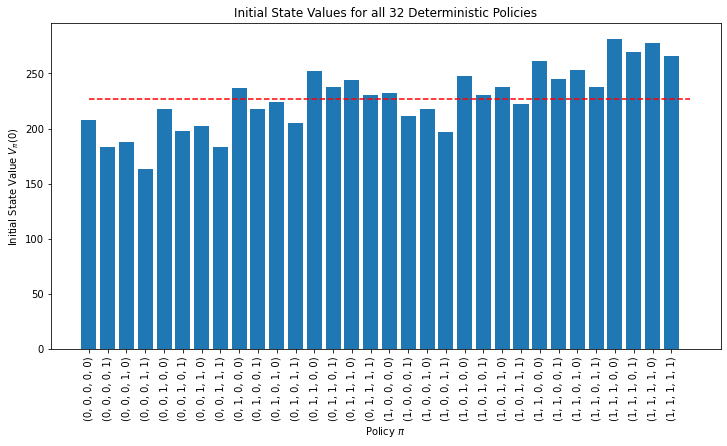

In [16]:
labels = [str(p) for p in policies]
fig, ax = plt.subplots(figsize=(12,6))
bars = plt.bar(range(32),[val[3] for val in state_values], label=policies)
plt.xlabel('Policy $\pi$')
plt.ylabel('Initial State Value $V_{\pi}(0)$')
# ax.set_xticklabels(labels)
plt.xticks(np.arange(32),rotation=90, labels=labels)
plt.hlines(y=tdlam_state_vals[3], xmin =0, xmax = 32, color = 'red', linestyle='dashed')
plt.title('Initial State Values for all 32 Deterministic Policies');

# Part III
## 1.) SARSA($\lambda$) algorithm
We now explore a new setup of the game that is very similar but with a slight wrinkle. Now the player can change her behavior depending on both the win counts and her energy level, leading to a total of $7*11=77$ possible states. I implement the SARSA($\lambda$) algorithm, which is analogous to TD($\lambda$) above, except that now the goal is to learn the action values, rather than evaluate the state values given a policy (i.e. control instead of prediction).

Another slight change is that while the target policy is still $\epsilon$-greedy, we have to add a constraint that accounts for the fact that if the player doesn't have enough energy remaining to invest high effort, her only option is to choose low effort.

Because there are 154 action values, I don't put them all into a table, but the output is visible below. Each of the seven 11x2 arrays corresponds to a different value of $d$, where the rows represent the different energy levels $B$ and the columns are each of the two actions. As $d$ and $B$ increase, we see a steady increase in the action values, which makes sense as players closer to victory and with more energy have more lucrative actions at their disposal. I do present a table below with the optimal deterministic policy given all possible states. A few things to note on this policy:

- The agent will almost always choose high effort, except when constrained to choose low effort. In fact, there are only two states in which the agent will choose low effort when it doesn't have to (bolded below).

- This makes sense, considering how high the initial value of $B=10$ is. Most episodes of the game will last far fewer than 10 rounds, so an agent could feasibly choose high effort, which is associated with a better win probability, and only very rarely run out of energy.

- This result is not very stable. If I rerun the algorithm (even over a much larger number of episodes), I still get a similar policy in terms of mostly all "High" actions, but it is not identical. This suggests that the algorithm hasn't converged, which could be due to the increased number of states to explore and the relative rarity of some of those states being visited - especially states where $B$ is very low.
       
| | B = 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| **d = -3** | High | High | High | High | High | High | High | High | High | High | High |
| **-2** | Low | High | High | High | High | High | High | High | High | High | High |
| **-1** | Low | **Low** | **Low** | High | High | High | High | High | High | High | High |
| **0** | Low | High | High | High | High | High | High | High | High | High | High |
| **1** | Low | High | High | High | High | High | High | High | High | High | High |
| **2** | Low | High | High | High | High | High | High | High | High | High | High |
| **3** | High | High | High | High | High | High | High | High | High | High | High |

In [17]:
def eps_greedy_lim(q_values, B, ch, eps=0.1):
    '''Typical eps-greedy policy, but must choose action 1 (low effort) if agent doesn't have enough energy'''
    if B < ch:
        return 1
    elif np.random.binomial(1, eps) == 1:
        return np.random.choice(np.arange(len(q_values)))
    else:
        return np.argmax(q_values)
    
env = tpg2.two_player_game2()

In [18]:
def sarsa_lambda(n_episodes=500000, gamma=0.9, lam=0.9, eta=0.001):
    Q = np.zeros((7,11,2)) 
#     elig = np.zeros((7,11,2))
    ch = env.get_ch() #Energy cost of high effort
    for ep in range(n_episodes):
        elig = np.zeros((7,11,2))
        #Initialize state (both d and B) and action
        d, B = env.reset()
        action = eps_greedy_lim(Q[d+3][B], B, ch) #Apply constrained eps-greedy policy
        done = False
        while not done:
            next_state, reward, done = env.step(action)
            next_d, next_B = next_state
            next_action = eps_greedy_lim(Q[next_d+3][next_B], next_B, ch)
            delta = reward + gamma*Q[next_d+3][next_B][next_action] - Q[d+3][B][action]
            elig[d+3][B][action] +=1 
            Q += eta*elig*delta
            elig *= gamma*lam
            d, B = next_state
            action = next_action
    return Q

In [19]:
np.random.seed(1)
sarsa_lam_vals = sarsa_lambda(n_episodes=500000)
print(sarsa_lam_vals)
np.argmax(sarsa_lam_vals, axis=2)

[[[  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]
  [  0.           0.        ]]

 [[  0.          52.7692215 ]
  [ 59.87996038  30.0271749 ]
  [ 66.89870865  52.08056313]
  [ 72.13947902  40.12434697]
  [ 77.81992035  56.08561941]
  [ 85.56124063  50.77670946]
  [ 90.88667662  72.88805286]
  [ 93.97212808  63.29249281]
  [ 96.08375897  78.56541201]
  [100.61059757  67.49102511]
  [ 98.67301856  69.38246708]]

 [[  0.         117.03888762]
  [108.10046067 132.60694382]
  [120.55733947 140.09871727]
  [169.30491905 141.80655124]
  [175.38767062 135.09624987]
  [182.31294892 166.13371957]
  [191.51337113 166.08273735]
  [190.32564484 181.43568629]
  [206.13928852 173.77607811]
  [200.63044118 180.4289073 ]
  [203.77049941 182.39694968]]

 [[ 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Part IV
## 1.) 
The described game is completely random with no strategy. In each round, each player will win with probability $p=\frac{1}{2}$. Determining player $X$'s win probability for $x=1$ and various values of $y$ just requires knowledge of basic probability:

- If $x=1$ and $y=1$, the player who wins the next round will win the entire game, so $P(win_X|x=1, y=1)=\frac{1}{2}$ 

- If $x=1$ and $y=2$, player $X$ must win each of the next two rounds consecutively in order to win the entire game, so $P(win_X|x=1,y=2)=(\frac{1}{2})^2=\frac{1}{4}$ 

- For any value of $y$, this same pattern holds that player $X$ must win the next $y$ games consecutively to win the game, so $P(win_X|x=1,y)=(\frac{1}{2})^y$ 

## 2.)
We now determine the win probability for the opposite scenario of $y=1$ and various values of $x$:

- Again, $y=1$ and $x=1$, the player who wins the next round will win the entire game, so $P(win_X|y=1,x=1)=\frac{1}{2}$ 

- If $y=1$ and $x=2$, then player $X$ must win in one of the next two rounds. Since each round occurs independently of any other, this scenario is equivalent to the probability of winning the first round *OR* losing the first round and winning the second. $$P(win_X|y=1,x=2) = \frac{1}{2} + (\frac{1}{2})^2 = \frac{3}{4}$$

- Continuing this pattern, for any value of $x$, player $X$ must win just one of the next $x$ rounds to win the game:
$$P(win_X |y=1, x) = \frac{1}{2} + (\frac{1}{2})^2 + ... + (\frac{1}{2})^x = \sum_{i=1}^x\frac{1}{2}^i$$

## 3.)

For any value of $x$ or $y$, there is a closed form solution to the problem that can be solved by realizing that the event of Player $X$ winning the game is a random variable that follows a Negative Binomial Distribution. From Player $X$'s standpoint, the chances of winning the game can be thought of as the probability of achieving $y$ successes before $x$ failures. The corresponding probability mass function is:
$$P(win_X|x,y) = \sum_{i=0}^{x-1} {y+i-1 \choose y-1}(1-p)^ip^y,$$ 
where $p = 0.5$ in this case. Another way to think about this intuitively is the probability of player $Y$ winning no more than $x-1$ times (any more would exhaust all of $X$'s tokens) before player $X$ wins $y$ times. Using this formula, here is a table with the win probability values for Player $X$ for each set of $(x,y) \in [1,10] x [1,10]$:


|  | y = 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| -- | ----- | -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| **x = 1** | 0.5000 | 0.2500 | 0.1250 | 0.0625 | 0.0312 | 0.0156 | 0.0078 | 0.0039 | 0.0020 | 0.0010 |
| **2** | 0.7500 | 0.5000 | 0.3125 | 0.1875 | 0.1094 | 0.0625 | 0.0352 | 0.0195 | 0.0107 | 0.0059 |
| **3** | 0.8750 | 0.6875 | 0.5000 | 0.3438 | 0.2266 | 0.1445 | 0.0898 | 0.0547 | 0.0327 | 0.0193 |
| **4** | 0.9375 | 0.8125 | 0.6562 | 0.5000 | 0.3633 | 0.2539 | 0.1719 | 0.1133 | 0.0730 | 0.0461 |
| **5** | 0.9688 | 0.8906 | 0.7734 | 0.6367 | 0.5000 | 0.3770 | 0.2744 | 0.1938 | 0.1334 | 0.0898 |
| **6** | 0.9844 | 0.9375 | 0.8555 | 0.7461 | 0.6230 | 0.5000 | 0.3872 | 0.2905 | 0.2120 | 0.1509 |
| **7** | 0.9922 | 0.9648 | 0.9102 | 0.8281 | 0.7256 | 0.6128 | 0.5000 | 0.3953 | 0.3036 | 0.2272 |
| **8** | 0.9961 | 0.9805 | 0.9453 | 0.8867 | 0.8062 | 0.7095 | 0.6047 | 0.5000 | 0.4018 | 0.3145 |
| **9** | 0.9980 | 0.9893 | 0.9673 | 0.9270 | 0.8666 | 0.7880 | 0.6964 | 0.5982 | 0.5000 | 0.4073 |
| **10** | 0.9990 | 0.9941 | 0.9807 | 0.9539 | 0.9102 | 0.8491 | 0.7728 | 0.6855 | 0.5927 | 0.500 0|

Just to sanity check these results, I also use Monte Carlo methods to simulate 50,000 games for each set of $(x,y) \in [1,10] x [1,10]$. The table below presents player $X$'s win probability for each pair of starting token values, and the values are almost identical to the table above.


|  | y = 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| -- | ----- | -- | -- | -- | -- | -- | -- | -- | -- | -- | 
| **x = 1** | 0.5012 | 0.2515 | 0.1240 | 0.0624 | 0.0316 | 0.0156 | 0.0068 | 0.0045 | 0.0022 | 0.0012 | 
| **2** | 0.7521 | 0.4984 | 0.3085 | 0.1890 | 0.1070 | 0.0638 | 0.0344 | 0.0193 | 0.0106 | 0.0051 | 
| **3** | 0.8766 | 0.6856 | 0.5003 | 0.3440 | 0.2260 | 0.1443 | 0.0894 | 0.0548 | 0.0332 | 0.0198 | 
| **4** | 0.9393 | 0.8134 | 0.6561 | 0.4972 | 0.3604 | 0.2510 | 0.1715 | 0.1156 | 0.0709 | 0.0451 | 
| **5** | 0.9692 | 0.8881 | 0.774 | 0.6369 | 0.4983 | 0.3767 | 0.2728 | 0.1939 | 0.1345 | 0.0901 | 
| **6** | 0.9842 | 0.9382 | 0.859 | 0.7473 | 0.6237 | 0.4978 | 0.3888 | 0.2887 | 0.2132 | 0.1518 | 
| **7** | 0.9924 | 0.9654 | 0.9119 | 0.8285 | 0.7272 | 0.6112 | 0.5012 | 0.3982 | 0.3080 | 0.2286 | 
| **8** | 0.9960 | 0.9816 | 0.9450 | 0.8888 | 0.8077 | 0.7083 | 0.6068 | 0.5030 | 0.4050 | 0.3167 | 
| **9** | 0.9981 | 0.9893 | 0.9672 | 0.9290 | 0.8673 | 0.7886 | 0.6958 | 0.5970 | 0.5050 | 0.4051 | 
| **10** | 0.9992 | 0.9941 | 0.9810 | 0.9523 | 0.9107 | 0.8494 | 0.7691 | 0.6867 | 0.5918 | 0.5019 |

We can see that when both players start with the same number of tokens, they have 50-50 odds of winning. Additionally, the results are as expected for a game like this, where $X$'s win probability increases down the rows and decreases across the columns. Finally, it is interesting to note for the non-diagonal entries in the matrix $X$ above, $X_{i,j} + X_{j,i} = 1$.

In [20]:
def dice_game(x, y, n_episodes=50000):
    if x <= 0 | y <=0 | (type(x) != int) | (type(y) != int):
        raiseValueError('x and y must be positive integers')
    wins = np.zeros(n_episodes)
    for ep in range(n_episodes): 
        tokens_x, tokens_y = x, y #Reset token counts
        while((tokens_x>0) & (tokens_y>0)):
            win_X = np.random.binomial(1, 0.5) #1 if X wins, 0 if Y wins
            if win_X:
                tokens_y -=1
            else:
                tokens_x -=1
            if tokens_y == 0:
                wins[ep] = 1 #Player X wins
            elif tokens_x == 0:
                wins[ep] = 0 #Player Y wins
    return wins

In [21]:
x = range(1,11)
y = range(1,11)
px = np.zeros_like(np.outer(x,y)).astype(float)

np.random.seed(1)
for i in x:
    print('x={}'.format(i), end='\t')
    for j in y:
        print(np.round(np.mean(dice_game(i, j)), 4), end='\t')
    print('')

x=1	0.5012	0.2515	0.124	0.0624	0.0316	0.0156	0.0068	0.0045	0.0022	0.0012	
x=2	0.7521	0.4984	0.3085	0.189	0.107	0.0638	0.0344	0.0193	0.0106	0.0051	
x=3	0.8766	0.6856	0.5003	0.344	0.226	0.1443	0.0894	0.0548	0.0332	0.0198	
x=4	0.9393	0.8134	0.6561	0.4972	0.3604	0.251	0.1715	0.1156	0.0709	0.0451	
x=5	0.9692	0.8881	0.774	0.6369	0.4983	0.3767	0.2728	0.1939	0.1345	0.0901	
x=6	0.9842	0.9382	0.859	0.7473	0.6237	0.4978	0.3888	0.2887	0.2132	0.1518	
x=7	0.9924	0.9654	0.9119	0.8285	0.7272	0.6112	0.5012	0.3982	0.308	0.2286	
x=8	0.996	0.9816	0.945	0.8888	0.8077	0.7083	0.6068	0.503	0.405	0.3167	
x=9	0.9981	0.9893	0.9672	0.929	0.8673	0.7886	0.6958	0.597	0.505	0.4051	
x=10	0.9992	0.9941	0.981	0.9523	0.9107	0.8494	0.7691	0.6867	0.5918	0.5019	
